# Einleitung PINA
Source: [PINA-Introduction](https://mathlab.github.io/PINA/_rst/tutorials/tutorial1/tutorial.html) <br>

In diesem Tutorial werden wir nach dem Standard -API -Verfahren einen typischen Anwendungsfall von Pina für ein Spielzeugproblem demonstrieren.<br>

Insbesondere zielt das Tutorial darauf ab, die folgenden Themen einzuführen:<br>

- Erklären, wie man <strong>PINA</strong> Probleme aufbaut,
- Zeigen, wie Daten für das `PINN` Training generiert werden

Dies sind die beiden Hauptschritte, die vor Beginn der Modellierungsoptimierung benötigt werden (Model und Löser und Zug). Wir werden jeden Schritt ausführlich zeigen und am Ende ein einfaches Problem mit der normalen Differentialgleichung (ODE) unter Verwendung des Pinn -Solvers lösen.

## Variablendeklaration
- `SpatialProblem`: Differentialgleichung mit Spatialen Variablen `spatial_domain`<br>
- `TimeDependentProblem`: Zeitabhängige Differentialgleichung mit zeitabhängigen Variablen `temporal_domain`<br>
- `ParametricProblem`: Parametrisierte Differentialgleichung mit parametrischen Variablen`parameter_domain`<br>
- `AbstractProblem`: Sonstige <strong>PINA</strong> Problemerben<br><br>

## Definitionen
- `Residual` : Differenz zwischen der linken und rechten Seite einer Differentialgleichung<br>
- `truth_solution` : Funktion, die die wahre Lösung der Differentialgleichung berechnet. <br>
$\rightarrow$ Hilfreich um die Vergleichbarkeit darzustellen<br>

## Problemdefinition
<strong>Annahme:</strong>
$$
\begin{cases}
  \frac{d}{dx}u(x) &= u(x) \quad \text{mit} \quad u(0) \in 1\\
  u(x=0) &=1\\
\end{cases}
$$
<strong>Analytische Lösung:</strong>
$$
u(x) = e^x \quad x \in (0,1)
$$

In [1]:
from pina.problem import SpatialProblem
from pina.operators import grad
from pina import Condition
from pina.geometry import CartesianDomain
from pina.equation import Equation, FixedValue

import torch

class SimpleODE(SpatialProblem): # Problem Class

    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0,1]})

    # defining the ode equation
    def ode_equation(input_, output_):

        # computing the derivative
        u_x = grad(output_, input_, components=['u'], d=['x'])

        #extracting the u input variable
        u = output_.extract(['u'])

        # calculate the residual and return it
        return u_x - u

    # conditions to hold
    conditions = {
        # We fix initial condition to value 1
        'x0': Condition(location=CartesianDomain({'x': 0.}), equation=FixedValue(1)),
        # We wrap the python equation using Equation
        'D': Condition(location=CartesianDomain({'x': [0,1]}), equation=Equation(ode_equation)),
    }

    # sample points (see below)labels
    input_pts = None

    # defining the true solution
    def truth_solution(self, pts):
        return torch.exp(pts.extract(['x']))

problem = SimpleODE()

## Datengenerierung (Trainingsdaten)
Daten für das Training können in Form von direkten numerischen Simulationsergebnissen oder Punkten in den Domänen vorliegen. Im Falle von unüberwachtem Lernen benötigen wir nur die Kollokationspunkte für das Training, d.h. Punkte, an denen wir das neuronale Netzwerk auswerten möchten.

### Erläuterung
- <strong>Direkte numerische Simulationsergebnisse:</strong> Dies sind Ergebnisse, die durch numerische Simulationen generiert wurden.
- <strong>Manuell definierte Punkte:</strong> Diese können unabhängig von Simulationsergebnissen festgelegt werden, um das Modell an bestimmten Stellen zu trainieren oder zu evaluieren.

### Beispiel
Drei Beispiele der Datengenerierung sind im folgenden Code dargestellt.

In [2]:
# sampling 20 points in [0, 1] through discretization in all locations
problem.discretise_domain(n=20, mode='grid', variables=['x'], locations='all')

# sampling 20 points in (0, 1) through latin hypercube sampling in D, and 1 point in x0
problem.discretise_domain(n=20, mode='latin', variables=['x'], locations=['D'])
problem.discretise_domain(n=1, mode='random', variables=['x'], locations=['x0'])

# sampling 20 points in (0, 1) randomly
problem.discretise_domain(n=20, mode='random', variables=['x'])

## Latin Hypercube Sampling (LHS)
Latin Hypercube Sampling ist eine Methode zur gleichmäßigen und effizienten Stichprobenentnahme aus einem mehrdimensionalen Raum. Dabei wird jede Dimension in gleich große Intervalle unterteilt, aus denen je ein Wert zufällig gewählt wird, sodass eine möglichst gleichmäßige Verteilung der Punkte entsteht. In PINA wird LHS genutzt, um die Eingabepunkte für das neuronale Netz optimal über den Definitionsbereich der Differentialgleichung zu verteilen und die Lösungsgüte zu verbessern.

### Beispiel

In [3]:
# sampling for training
problem.discretise_domain(1, 'random', locations=['x0'])
problem.discretise_domain(20, 'lh', locations=['D'])

### Abrufen der Daten
Mithilfe von `dict` `input_pts`

In [4]:
print('Input points:', problem.input_pts)
print('Input points labels:', problem.input_pts['D'].labels)

Input points: {'x0': LabelTensor([[[0.]]]), 'D': LabelTensor([[[0.4614]],
             [[0.8688]],
             [[0.9784]],
             [[0.6441]],
             [[0.8451]],
             [[0.6777]],
             [[0.0502]],
             [[0.0437]],
             [[0.1090]],
             [[0.9000]],
             [[0.1853]],
             [[0.5405]],
             [[0.3527]],
             [[0.2724]],
             [[0.5733]],
             [[0.7434]],
             [[0.2340]],
             [[0.3400]],
             [[0.7919]],
             [[0.4405]]])}
Input points labels: ['x']


## Visualisierung
Mithilfe von `.plot_samples` `Plotter`

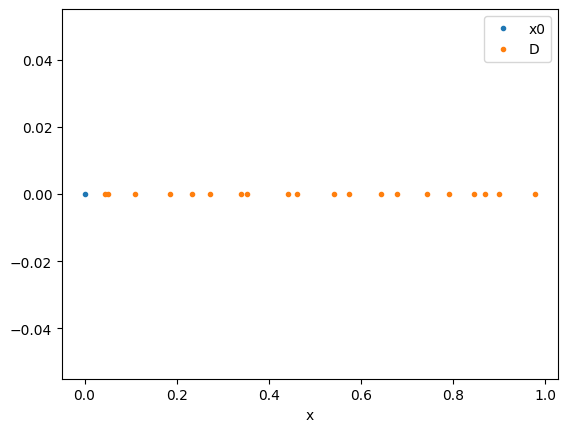

In [5]:
from pina import Plotter

pl = Plotter()
pl.plot_samples(problem=problem)

## Beispiel Training
Anhand eines sehr einfachen Beispiels

In [6]:
from pina import Trainer
from pina.solvers import PINN
from pina.model import FeedForward
from pina.callbacks import MetricTracker
import torch

# build the model
model = FeedForward(
    layers=[10, 10],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# create the PINN object
pinn = PINN(problem, model)

# create the trainer
trainer = Trainer(solver=pinn,
                  max_epochs=1500,
                  callbacks=[MetricTracker()],
                  accelerator='cpu',
                  enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)

# train
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\lukas\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\lukas\miniconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...

KeyboardInterrupt



## Ergebnisse der Modellierung
`trainer.logged_metrics` enthält den finalen Verlust und weitere Metriken, die während des Trainings protokolliert wurden. Standardmäßig wird der Verlust als `mean square error` gespeichert.

In [10]:
# inspecting final loss
trainer.logged_metrics

{'x0_loss': tensor(8.6703e-07),
 'D_loss': tensor(9.2456e-05),
 'mean_loss': tensor(4.6661e-05)}

## Visualisierung der Ergebnisse

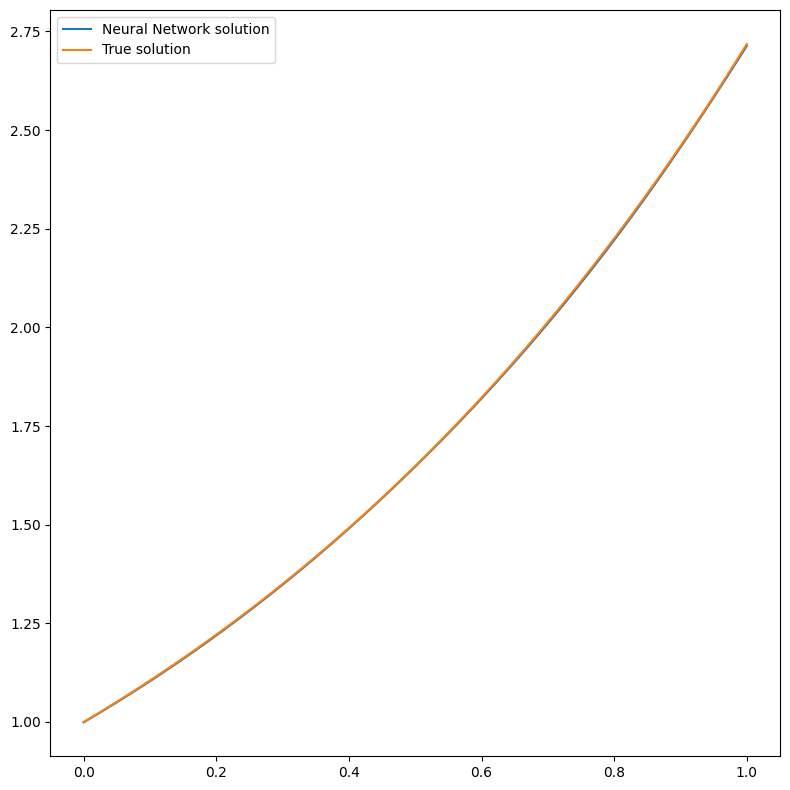

In [11]:
# plotting the solution
pl.plot(solver=pinn)

## Visualisierung der Loss-Kurve

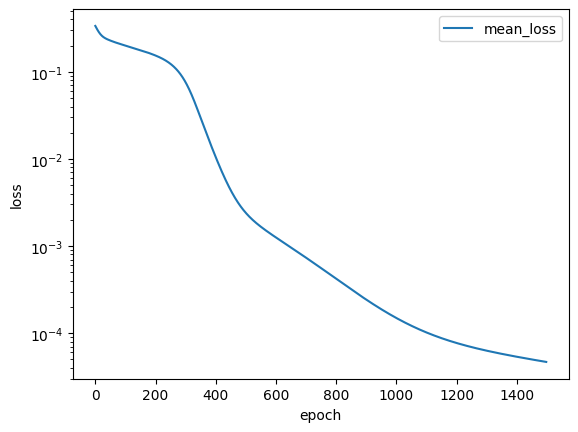

In [12]:
pl.plot_loss(trainer=trainer, label='mean_loss', logy=True)

### Erkenntnis
- Der Verlust hat nicht das Minimum erreicht. Man könnte länger trainieren.

## Weitere Optimierungsmöglichkeiten
1. Das Netzwerk länger Trainieren mit unterschiedlichen Layergrößen und Verbesserung der finalen Genauigkeit
2. Das netzwerk mit anderen Modeltypen testen
3. GPU Training und Speed Benchmarking